In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use("opinionated_rc")

df = pd.read_parquet("plos-processed.parquet")
df = df.astype({"publish_date": "datetime64[ns]"})

print(df.columns)
df.sample(3)

Index(['journal_name', 'journal_pmc_id', 'doi', 'full_title', 'short_title',
       'abstract', 'disciplines', 'repository_url',
       'acknowledgement_statement', 'funding_statement', 'funding_sources',
       'publish_date', 'full_name', 'email', 'affliation', 'roles'],
      dtype='object')


,journal_name,journal_pmc_id,doi,full_title,short_title,abstract,disciplines,repository_url,acknowledgement_statement,funding_statement,funding_sources,publish_date,full_name,email,affliation,roles
7452,PLoS Comput Biol,ploscomp,10.1371/journal.pcbi.1011874,How neuronal morphology impacts the synchronis...,Neuronal morphology impacts neural network syn...,\n,Physical sciences;Computer and information sci...,https://github.com/rpgowers/morph-excite-code,\n,This project has received funding from the Eur...,H2020 European Research Council,2024-03-04,Susanne Schreiber,None,None,Conceptualization;Funding acquisition;Supervis...
550,PLoS ONE,plosone,10.1371/journal.pone.0213090,An analysis and metric of reusable data licens...,Reusable data for biomedical resources,\n,Medicine and health sciences;Science policy;Bi...,https://github.com/reusabledata/reusabledata,\n,This work was support by the National Institut...,National Institutes of Health,2019-03-27,Robin Champieux,None,None,Data curation;Funding acquisition;Methodology;...
7451,PLoS Comput Biol,ploscomp,10.1371/journal.pcbi.1011874,How neuronal morphology impacts the synchronis...,Neuronal morphology impacts neural network syn...,\n,Physical sciences;Computer and information sci...,https://github.com/rpgowers/morph-excite-code,\n,This project has received funding from the Eur...,H2020 European Research Council,2024-03-04,Robert P. Gowers,None,None,Conceptualization;Formal analysis;Investigatio...


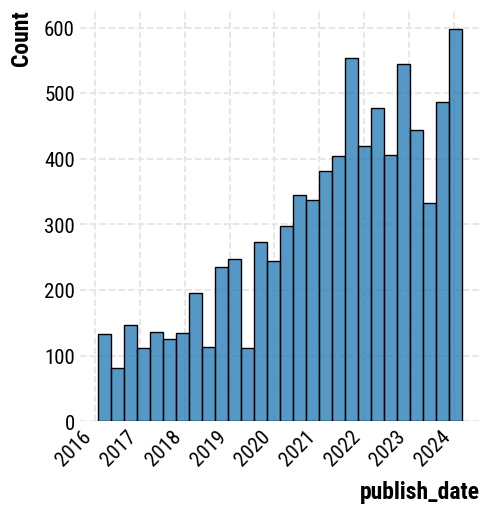

In [31]:
sns.displot(df, x="publish_date")
_ = plt.xticks(rotation=45, ha="right")

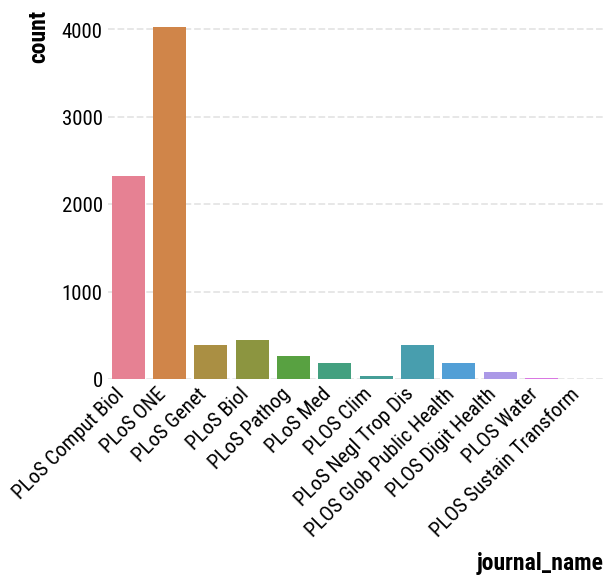

In [19]:
sns.countplot(data=df, x="journal_name", hue="journal_name")
_ = plt.xticks(rotation=45, ha="right")

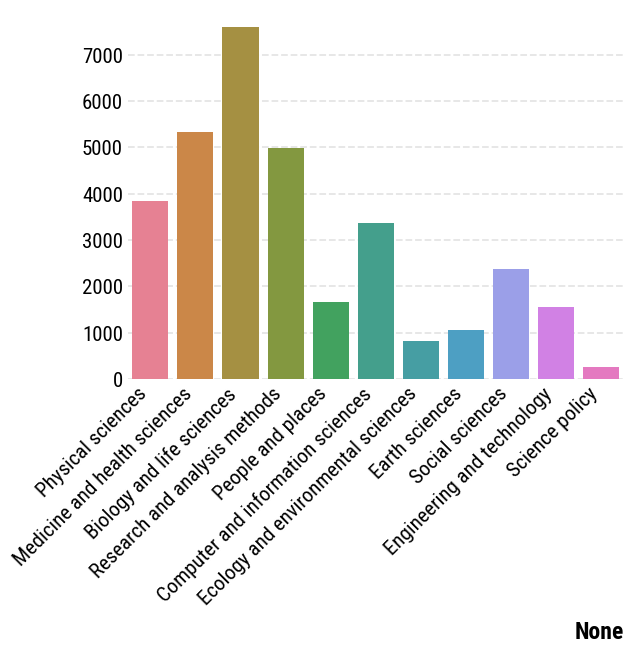

In [26]:
# Process disciplines by splitting by ";"
disc_counts = {}
for disc in df["disciplines"]:
    for d in disc.split(";"):
        if d not in disc_counts:
            disc_counts[d] = 0
        disc_counts[d] += 1
discipline_counts = pd.Series(disc_counts)
sns.barplot(
    x=discipline_counts.index, y=discipline_counts.values, hue=discipline_counts.index
)
_ = plt.xticks(rotation=45, ha="right")

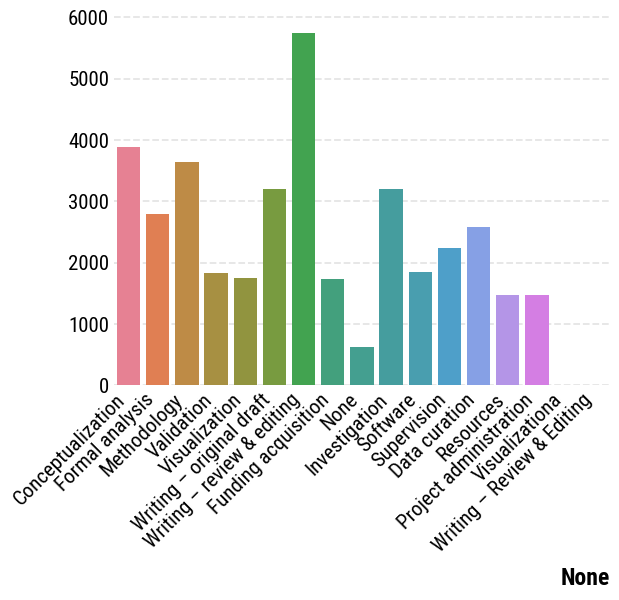

In [29]:
# Process roles by splitting by ";"
role_counts_dict = {}
for roles in df["roles"]:
    if roles is None:
        if "None" not in role_counts_dict:
            role_counts_dict["None"] = 0
        role_counts_dict["None"] += 1
    else:
        for r in roles.split(";"):
            if r not in role_counts_dict:
                role_counts_dict[r] = 0
            role_counts_dict[r] += 1
role_counts = pd.Series(role_counts_dict)
sns.barplot(x=role_counts.index, y=role_counts.values, hue=role_counts.index)
_ = plt.xticks(rotation=45, ha="right")